pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import random

# ML
from sklearn.ensemble import RandomForestClassifier  # Bagging
from xgboost.sklearn import XGBClassifier            # GBM
from sklearn.linear_model import LogisticRegression  # LogisticRegression
from sklearn.svm import SVC                          # SVM

# DL
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, ReLU, Softmax, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# for checking multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : for optuna
from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial

# AutoML framework
import optuna

In [2]:
# set configs
is_tuning = True
is_scaling = True
is_pca = True
if is_tuning:
    n_trials=1000
    
# Keras model compile
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [4]:
def balance_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred /= np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    if len(nc) == 1:
        return np.nan
    elif len(nc) == 2:
        logloss = (-1 / nc[0] * (np.sum(np.where(y_true == 0, 1, 0) * np.log(y_pred[:, 0])))
                   - 1 / nc[1] * (np.sum(np.where(y_true != 0, 1, 0) * np.log(y_pred[:, 1])))) / 2
        return logloss
    else:
        raise ValueError("Expected two classes in y_true.")


# def balance_loglossv2(y_true, y_pred):
#     from sklearn.metrics import log_loss
    
#     target_mean = y_true.mean()
#     w0 = 1/(1-target_mean)
#     w1 = 1/target_mean
#     sample_weight = [w0 if y == 0 else w1 for y in y_true]
#     loss = log_loss(y_true, y_pred, sample_weight=sample_weight)
    
#     return loss

def b_logloss_keras(y_true, y_pred):
    y_true = y_true[:, 1] * (1 - y_true[:, 0])
    y_true = tf.cast(y_true, tf.int64)
    score = tf.py_function(func=balance_logloss, inp=[y_true, y_pred], Tout=tf.float32)
    return score


In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
greeks = pd.read_csv('./greeks.csv')
submission = pd.read_csv('./sample_submission.csv')

In [6]:
# train으로 test셋 만들기
train.Class.value_counts() # 0 : 509, 1 : 108

0    509
1    108
Name: Class, dtype: int64

In [7]:
# 60개(class : 0, class : 1) 테스트 셋 만들기
## 30개 class : 0
mask = train.Class == 0
test =  train[mask][:30]
dropIndex1 = train[mask][:30].index

In [8]:
## 30개 class : 1
mask = train.Class == 1
test = test.append(train[mask][:30]) 
dropIndex2 = train[mask][:30].index
test.Class.value_counts() # 0 : 30, 1 : 30
print(test.shape)
test = test.drop(columns = ['Class'], axis = 1)
print(test.shape)

(60, 58)
(60, 57)


/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_71068/2407644979.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(train[mask][:30])


In [9]:
# drop
print(train.shape)
train = train.drop(index=dropIndex1)
train = train.drop(index=dropIndex2)
print(train.shape)

(617, 58)
(557, 58)


In [10]:
test.to_csv('./test(make).csv',index = False)
train.to_csv('./train(make).csv',index = False)

In [11]:
train_make = pd.read_csv('./train(make).csv')
test_make = pd.read_csv('./test(make).csv')

In [12]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_make.EJ = lb.fit_transform(train_make.EJ)  # A->0, B->1

train_make = train_make.drop(columns=["Id"])

In [13]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5)
data = imp.fit_transform(train_make)
train = pd.DataFrame(columns=train_make.columns,
                    data=data)
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.226469,2386.38862,85.200147,8.937942,9.706644,4.172589,0.025578,3.396778,3.795120,5243.79705,...,0.173229,1.08750,0.067730,13.134424,72.611063,36639.453980,38.717005,102.501916,21.978000,0.0
1,0.397389,2451.22889,104.986995,67.852173,8.138688,7.539009,0.025578,12.793060,1.229900,4251.61483,...,4.226611,0.80591,1.246232,27.329276,94.408958,56896.666140,31.234074,21.921156,0.198000,0.0
2,0.119644,3380.98442,85.200147,4.270763,8.138688,2.910182,0.025578,7.619118,1.229900,4260.77936,...,12.203187,1.19712,0.067730,6.762554,386.805524,2520.014490,34.076918,47.440540,0.170500,0.0
3,0.200831,2043.07774,85.200147,7.767276,8.138688,6.210159,0.025578,9.887838,4.188688,5692.79510,...,0.173229,1.17044,0.067730,28.789690,105.694393,17473.863190,28.763330,33.860380,21.978000,0.0
4,0.324748,1696.64506,85.200147,14.661198,8.138688,5.722914,0.025578,10.341582,1.229900,4599.08395,...,0.173229,0.49706,0.535067,8.092740,151.428011,28567.525660,24.093475,22.816212,21.978000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0
553,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0
554,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0
555,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0.0


In [14]:
[variance_inflation_factor(train, i) for i in range (train.shape[1])]

[7.914879889551644,
 5.734677885372059,
 12.440794126463055,
 3.293607931986981,
 15.526653471839058,
 10.455381694443288,
 8.212145357415244,
 9.717723950336921,
 36.20985100088126,
 22.77906790092238,
 49.042293062657826,
 4.428982415871704,
 3.3706624894646677,
 1.4467363430883622,
 35.81645473798517,
 1.4931694468237589,
 13.541935866520765,
 7.89203270270877,
 3.271512423426108,
 20.446392316739686,
 17.912389047115298,
 11.12011725219816,
 24.92025492712033,
 13.362364065157212,
 5.442563961248806,
 11.908565165885586,
 3.421292942436951,
 2.1486833177066997,
 19.592400096591025,
 9.503197875794612,
 18.089751455717938,
 19.72105671040967,
 25.142714295225705,
 49.50075171726749,
 3.9801900723468027,
 14.283438449384585,
 4.7244094896887985,
 2.2324527750715726,
 38.03948065971543,
 42.104190824265956,
 5.930476582379446,
 23.114658712767056,
 1.3896670330725667,
 1.8204470054164874,
 27.011465243708585,
 2.2294426471366475,
 19.97016670888458,
 4.270234628150088,
 2.041363253360

In [15]:
def check_vif(df):
    vifs = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif_df = pd.DataFrame({"features":df.columns, "VIF" : vifs})
    vif_df = vif_df.sort_values(by="VIF", ascending=False)
    remove_col = vif_df.iloc[0, 0]
    top_vif = vif_df.iloc[0, 1]
    return vif_df, remove_col, top_vif

In [16]:
# remove all features when VIF is over 10.
top_vif = 100

while(top_vif > 15):
    vif_df, remove_col, top_vif = check_vif(train)
    print(remove_col, top_vif)
    if top_vif < 15:
        break
    train = train.drop(columns=remove_col)

train

DV 49.50075171726749
BN 49.04213013288845
EH 37.9594637625502
BC 35.07416944516293
EJ 31.65328404129584
CS 24.674187559090253
BD  19.83882065451412
CH 19.357331905373705
DH 18.676352757675485
EP 18.192223147191356
FI 17.832289051851266
DN 17.357999669462227
DU 16.151963824824023
DL 15.998874334675712
EB 13.035049253512923


,AB,AF,AH,AM,AR,AX,AY,AZ,BP,BQ,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.226469,2386.38862,85.200147,8.937942,9.706644,4.172589,0.025578,3.396778,216.968976,47.158315,...,0.173229,1.08750,0.067730,13.134424,72.611063,36639.453980,38.717005,102.501916,21.978000,0.0
1,0.397389,2451.22889,104.986995,67.852173,8.138688,7.539009,0.025578,12.793060,185.481684,46.731095,...,4.226611,0.80591,1.246232,27.329276,94.408958,56896.666140,31.234074,21.921156,0.198000,0.0
2,0.119644,3380.98442,85.200147,4.270763,8.138688,2.910182,0.025578,7.619118,182.293956,224.092520,...,12.203187,1.19712,0.067730,6.762554,386.805524,2520.014490,34.076918,47.440540,0.170500,0.0
3,0.200831,2043.07774,85.200147,7.767276,8.138688,6.210159,0.025578,9.887838,262.669635,31.624700,...,0.173229,1.17044,0.067730,28.789690,105.694393,17473.863190,28.763330,33.860380,21.978000,0.0
4,0.324748,1696.64506,85.200147,14.661198,8.138688,5.722914,0.025578,10.341582,124.058574,29.472970,...,0.173229,0.49706,0.535067,8.092740,151.428011,28567.525660,24.093475,22.816212,21.978000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,167.877117,27.287375,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0
553,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,285.628059,344.644105,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0
554,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,178.661133,103.988995,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0
555,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,119.162529,82.512333,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0.0


<Axes: >

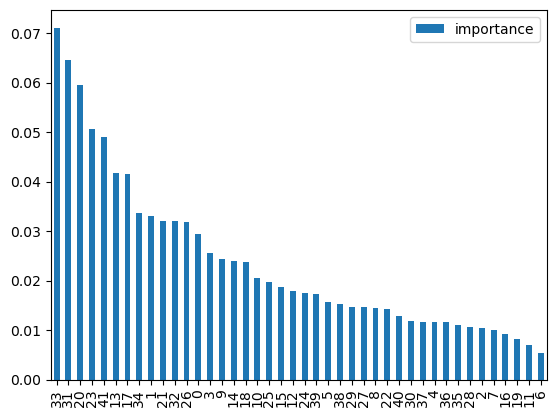

In [17]:
# feature selection via Feature Importance
X = train.drop(columns=['Class'])
y = train['Class']

rf = RandomForestClassifier()
rf.fit(X, y)
# [(col, fi) for col, fi in zip(X.columns, rf.feature_importances_)]
fi_df = pd.DataFrame({'feature': X.columns, 'importance' : rf.feature_importances_})

fi_df.sort_values(by='importance', ascending=False).plot(kind='bar')

In [18]:
# featrue 고름

selected_cols = fi_df.sort_values(by='importance', ascending=False)[:10]['feature'].values
selected_cols

array(['FL', 'FD ', 'DA', 'DI', 'GL', 'CC', 'CR', 'FR', 'AF', 'DE'],
      dtype=object)

In [19]:
# class imbalance handling

## 1. undersampling
c1 = train[train.Class==1]
c0 = train[train.Class==0]

print(c1.shape, c0.shape)
c0 = c0.sample(n=c1.shape[0])
train = pd.concat([c0, c1])
train.shape

(78, 43) (479, 43)


(156, 43)

In [20]:
X = train.drop(columns = ['Class'])
y = train['Class']

##### Oversampling


df = train[selected_cols]
df['Class'] = train['Class']
pd.pivot_table(index='Class', data=df)

## 2. oversampling = SMOTE
from imblearn.over_sampling import SMOTE

X = train[selected_cols]
y = train['Class']

smote = SMOTE(k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

## 3. hybrid approach

## class0 : 509 -> 300
## class1 : 108 -> 300

# class imbalance handling
## 1. undersampling

if sampling_method == 'hybrid':
    N = 300
    c1 = train[train.Class == 1]
    c0 = train[train.Class == 0]
    print(c1.shape, c0.shape)
    c0 = c0.sample(n=N)
    


df = X_resampled.copy()
df['Class'] = y_resampled
pd.pivot_table(index='Class', data=df)

X = X_resampled
y = y_resampled

In [21]:
# to make OOF prediction
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(132, 42) (24, 42) (132,) (24,)


##### Feature Scailing

In [22]:
from sklearn.preprocessing import StandardScaler

if is_scaling:
    scaler = StandardScaler()
    data_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=X_train.columns)
    data_ = scaler.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=X_val.columns)
    display(X_train)

,AB,AF,AH,AM,AR,AX,AY,AZ,BP,BQ,...,FE,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.392118,0.762163,-0.285049,-0.256987,-0.215336,0.110933,-0.309440,4.269345,-0.025398,0.494035,...,-0.309856,0.223855,-0.066159,-0.678909,2.434108,-0.467767,0.021705,-0.621655,3.116259,-0.739724
1,-0.644180,-0.307635,-0.285049,-0.388580,-0.215336,-0.136606,-0.309440,-1.548123,-0.157480,0.103982,...,-0.326535,0.178825,0.002830,0.027535,0.161926,-0.467767,-0.581669,-1.722975,0.604709,-0.737367
2,-0.461135,-0.859292,-0.082351,0.990614,-0.215336,-0.725750,-0.309440,-0.011666,-0.027807,-0.886094,...,-0.256523,-0.532640,-0.266421,-0.802537,0.757444,-0.467767,0.205987,-0.721254,-0.123181,1.398400
3,-0.428127,0.846464,-0.285049,-0.376792,0.352881,-0.545046,-0.309440,0.014330,-0.365017,-0.322535,...,-0.247002,-0.059181,-0.157409,0.062857,-0.196702,-0.467767,-0.656522,1.039283,2.313245,-0.745008
4,-0.512148,-0.552814,0.463682,-0.387927,-0.215336,0.497095,-0.309440,-0.159428,-0.276319,-1.029910,...,0.053665,-0.532640,-0.201981,-0.166737,-0.400033,-0.342602,4.142079,1.347395,0.309003,1.398400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,-0.350108,-0.718502,-0.285049,-0.186976,-0.215336,-0.505440,-0.081782,0.015698,-0.129269,-0.973893,...,-0.206870,0.250965,-0.075638,-0.449315,-1.037008,-0.467767,0.178885,-1.615494,-0.173538,-0.745710
128,-0.326102,-0.060713,-0.285049,-0.317667,-0.215336,0.172818,-0.065899,-0.598612,-0.229211,-0.745130,...,-0.064132,0.396627,-0.266421,-0.802537,-0.232235,1.215615,-0.611934,0.796376,0.498122,-0.743154
129,-0.068039,-0.252554,-0.285049,-0.142468,-0.215336,0.053999,-0.309440,-0.750479,-0.058598,0.303517,...,-0.690649,0.366295,-0.029438,0.221807,-0.222365,-0.323677,-0.522520,-0.493752,-0.307473,-0.745349
130,0.526106,4.172973,-0.285049,-0.263705,-0.116847,0.123310,-0.309440,0.348164,-0.424770,0.434755,...,0.441101,-0.532640,-0.266421,-0.802537,-0.773795,-0.467767,-0.694522,2.886521,-0.398048,1.398400


In [23]:
if is_pca:
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=0.80, random_state=42)
    data_ = pca.fit_transform(X_train)
    X_train = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])
    data_ = pca.transform(X_val)
    X_val = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

    display(X_train)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,0.688834,-0.196501,-0.240070,-0.278718,-1.938537,2.826780,-0.411813,0.759158,1.981406,1.051855,1.072068,0.499131,1.862414,-0.527621,-0.786216,0.880233,-1.886596
1,-1.814920,-0.139230,0.643699,1.478716,0.090117,-1.024649,0.473478,0.283615,0.961515,0.746971,0.644625,0.790024,0.454140,-1.389987,-0.009808,0.046738,-0.035956
2,-0.917853,-0.199629,1.017720,-2.226340,0.060193,-0.059617,0.240653,-0.474430,-0.184072,-0.926095,-1.637496,0.281711,-0.523881,-0.723455,-0.114258,0.529485,0.188271
3,-0.566885,-0.485386,-0.306421,0.324068,0.815976,1.491285,-0.514873,0.210352,-0.318445,-0.496020,-0.050357,-0.741974,-0.803838,-1.914495,-2.485984,0.121995,-0.087501
4,-0.699429,-0.266628,-0.248031,-3.095622,0.753613,1.261729,-0.476798,0.161546,0.001971,-0.743314,-0.055618,1.213132,-1.897092,-0.672475,1.585975,-0.508291,-0.003287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,-2.007599,0.904280,-0.005502,0.799373,-0.486064,-0.771024,0.629872,0.588931,0.783388,0.399054,0.898730,1.058611,0.755303,0.052378,0.805078,0.441543,-0.774988
128,-0.748266,-0.551205,0.344016,0.387007,0.129290,0.621902,-0.071201,-0.182882,-1.053330,-0.131092,-0.061099,0.060131,0.705553,0.240674,-0.445293,-0.939217,0.181531
129,-1.092305,-0.782549,-0.362427,0.896023,-0.257992,-1.455000,0.965630,-0.523454,0.662454,0.183386,-0.374885,-0.275522,0.127274,-1.467798,-0.433131,-0.811131,-0.399457
130,0.758044,-1.854553,-0.926218,0.173368,0.765391,1.197930,-2.210128,-0.353614,-0.941495,-2.873919,2.183056,-2.735567,0.133981,-0.546637,0.660334,0.132806,-0.431095


In [24]:
# Model ensemble of SVM, Logistic Regression, XGBoost, RandomForest, Simple NN.

svm = SVC(random_state=42)
lr = LogisticRegression(random_state=42, max_iter=500)
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.8, reg_lambda=1, objective='binary:logistic', random_state=42)
rf = RandomForestClassifier(max_depth=8, max_features=0.8, criterion='log_loss', random_state=42)
nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(30), ReLU(), Dropout(0.2),
    Dense(20), ReLU(), Dropout(0.2),
    Dense(10), ReLU(), Dropout(0.1),
    Dense(2), Softmax()
])
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                540       
                                                                 
 re_lu (ReLU)                (None, 30)                0         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 re_lu_1 (ReLU)              (None, 20)                0         
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [25]:
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.8)   # [0.8, 0.2] <--> [0.9, 0] // [0, 0.9]
scheduler = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=10,
                              min_lr=1e-6)
earlystopper = EarlyStopping(monitor='val_loss',
                             patience=20,
                             min_delta=1e-2)


nn.compile(optimizer=optimizer, loss=loss_fn, metrics=[b_logloss_keras])

nn_y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
nn_y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [26]:
print("\nFitting LogisticRegression...")
lr.fit(X_train, y_train)
print("\nFitting SVM...")
svm.fit(X_train, y_train)
print("\nFitting RandomForest...")
rf.fit(X_train, y_train)
print("\nFitting XGBoost...")
xgb.fit(X_train, y_train)
print("\nFitting MLP...")

print(X_train, y_train)

history = nn.fit(X_train, nn_y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=[X_val, nn_y_val],
                callbacks=[scheduler, earlystopper])


Fitting LogisticRegression...

Fitting SVM...

Fitting RandomForest...

Fitting XGBoost...

Fitting MLP...
          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.688834 -0.196501 -0.240070 -0.278718 -1.938537  2.826780 -0.411813   
1   -1.814920 -0.139230  0.643699  1.478716  0.090117 -1.024649  0.473478   
2   -0.917853 -0.199629  1.017720 -2.226340  0.060193 -0.059617  0.240653   
3   -0.566885 -0.485386 -0.306421  0.324068  0.815976  1.491285 -0.514873   
4   -0.699429 -0.266628 -0.248031 -3.095622  0.753613  1.261729 -0.476798   
..        ...       ...       ...       ...       ...       ...       ...   
127 -2.007599  0.904280 -0.005502  0.799373 -0.486064 -0.771024  0.629872   
128 -0.748266 -0.551205  0.344016  0.387007  0.129290  0.621902 -0.071201   
129 -1.092305 -0.782549 -0.362427  0.896023 -0.257992 -1.455000  0.965630   
130  0.758044 -1.854553 -0.926218  0.173368  0.765391  1.197930 -2.210128   
131  0.218491 -0.336641 -0.793841 -2.164986  

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_71068/209746620.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  logloss = (-1 / nc[0] * (np.sum(np.where(y_true == 0, 1, 0) * np.log(y_pred[:, 0])))
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_71068/209746620.py:9: RuntimeWarning: invalid value encountered in double_scalars
  logloss = (-1 / nc[0] * (np.sum(np.where(y_true == 0, 1, 0) * np.log(y_pred[:, 0])))


3/3 [==============================] - 0s 12ms/step - loss: 0.7116 - b_logloss_keras: nan - val_loss: 0.7032 - val_b_logloss_keras: 0.6675 - lr: 0.0010
Epoch 9/10
3/3 [==============================] - 0s 13ms/step - loss: 0.7207 - b_logloss_keras: 0.6620 - val_loss: 0.7035 - val_b_logloss_keras: 0.6671 - lr: 0.0010
Epoch 10/10
3/3 [==============================] - 0s 11ms/step - loss: 0.7210 - b_logloss_keras: 0.6456 - val_loss: 0.7038 - val_b_logloss_keras: 0.6673 - lr: 0.0010


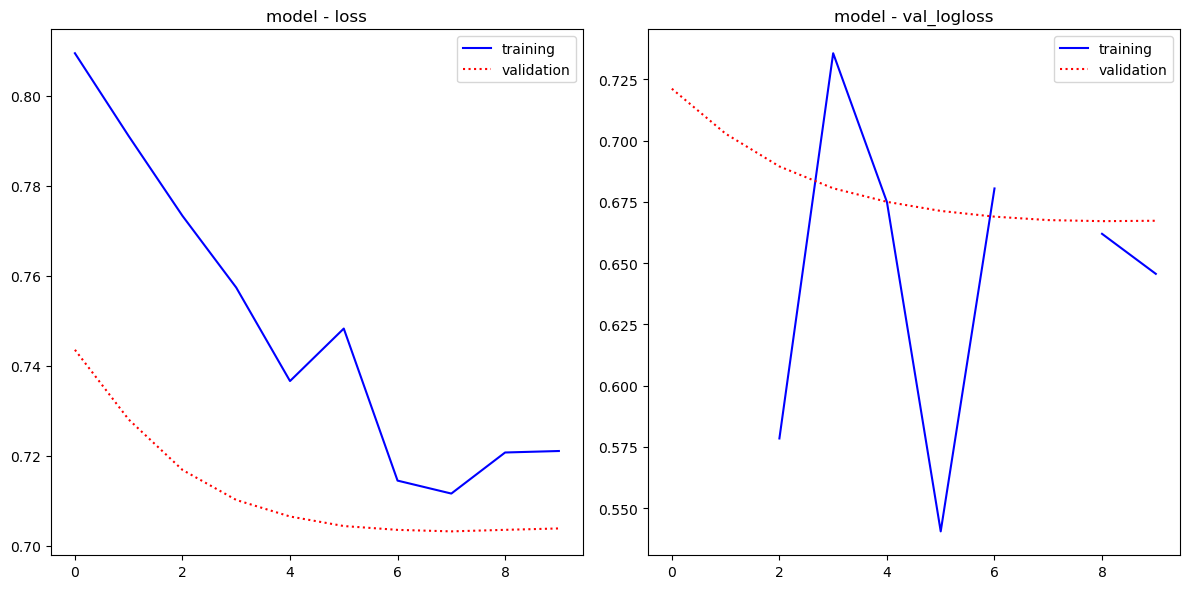

In [27]:
## loss visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(history.history['loss'],'b-', label = "training")
plt.plot(history.history['val_loss'], 'r:', label = "validation")
plt.title("model - loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("model - val_logloss")

plt.plot(history.history['b_logloss_keras'], 'b-', label = "training")
plt.plot(history.history['val_b_logloss_keras'], 'r:', label = "validation")

plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# set metric
evaluation_metric = balance_logloss
evaluation_metric_keras = b_logloss_keras

In [29]:
print("--- Prediction with XGB ---")
pred_train = xgb.predict_proba(X_train)
pred_val = xgb.predict_proba(X_val)

train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

print("--- Prediction with MLP ---")
pred_train = nn.predict(X_train)
pred_val = nn.predict(X_val)

train_score = evaluation_metric_keras(nn_y_train, pred_train)
val_score = evaluation_metric_keras(nn_y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

--- Prediction with XGB ---
Train Score : 0.0246
Test Score : 0.8096
--- Prediction with MLP ---
1/1 [==============================] - 0s 9ms/step
Train Score : 0.6441
Validation Score : 0.6673


In [37]:
def rf_optimizer(trial, X, y, K):
    # define parameter to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    max_features = trial.suggest_float('max_features', 0.6, 0.8, log=True)
    
    
    # set model
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   criterion='log_loss',
                                   class_weight='balanced'
                                  )
    
    # K-Fold Cross validation
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    # return mean score of CV
    return np.mean(losses)

In [39]:
def svm_optimizer(trial, X, y, K):
    C = trial.suggest_int('C', 1, 100)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'precomputed'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    

    model = SVC(C=C,
                kernel=kernel,
                class_weight='balanced', # if class imbalanced
                gamma=gamma,
                probability=True,
                cache_size=1000,
                random_state=42
               )
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [40]:
def lr_optimizer(trial, X, y, K):

    C = trial.suggest_int('C', 5, 100)
    solver = trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'newton-cholesky', 'saga'])    
    

    model = LogisticRegression(C=C,
                               solver=solver,
                               max_iter=500,
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [41]:
def xgb_optimizer(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 2, log=True)
    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    
    
    model = XGBClassifier(n_estimators=n_estimators,
                          max_depth=max_depth,
                          booster=booster,
                          colsample_bytree=colsample_bytree,
                          learning_rate=learning_rate,
                          reg_lambda=reg_lambda,
                          scale_pos_weight=4.71)
    
    
    folds = StratifiedKFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    return np.mean(losses)

In [ ]:
K = 15 # set K of K-Fold
opt_func = partial(rf_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    rf_study = optuna.create_study(direction="minimize") # determine minimize or maximize sth
    rf_study.optimize(opt_func, n_trials=n_trials)

[I 2023-06-19 19:24:27,694] A new study created in memory with name: no-name-4b98293a-f0db-4217-81da-f1568936c303
[I 2023-06-19 19:24:28,775] Trial 0 finished with value: 0.4922087367183859 and parameters: {'n_estimators': 85, 'max_depth': 8, 'max_features': 0.6502300746175274}. Best is trial 0 with value: 0.4922087367183859.
[I 2023-06-19 19:24:33,744] Trial 1 finished with value: 0.4861815262777035 and parameters: {'n_estimators': 426, 'max_depth': 14, 'max_features': 0.6432295040512667}. Best is trial 1 with value: 0.4861815262777035.
[I 2023-06-19 19:24:39,547] Trial 2 finished with value: 0.49357375137208287 and parameters: {'n_estimators': 469, 'max_depth': 8, 'max_features': 0.653892586516386}. Best is trial 1 with value: 0.4861815262777035.
[I 2023-06-19 19:24:43,552] Trial 3 finished with value: 0.49557159065070083 and parameters: {'n_estimators': 309, 'max_depth': 10, 'max_features': 0.7911559436549903}. Best is trial 1 with value: 0.4861815262777035.
[I 2023-06-19 19:24:46,5

[I 2023-06-19 19:27:13,872] Trial 38 finished with value: 0.4942546133355794 and parameters: {'n_estimators': 475, 'max_depth': 17, 'max_features': 0.6528698057936265}. Best is trial 26 with value: 0.48527715880730804.
[I 2023-06-19 19:27:18,707] Trial 39 finished with value: 0.4841498419009759 and parameters: {'n_estimators': 418, 'max_depth': 9, 'max_features': 0.6446108915190155}. Best is trial 39 with value: 0.4841498419009759.
[I 2023-06-19 19:27:24,613] Trial 40 finished with value: 0.4970972394430305 and parameters: {'n_estimators': 496, 'max_depth': 9, 'max_features': 0.6910739114660337}. Best is trial 39 with value: 0.4841498419009759.
[I 2023-06-19 19:27:29,695] Trial 41 finished with value: 0.48998330789636374 and parameters: {'n_estimators': 423, 'max_depth': 8, 'max_features': 0.6403809774063136}. Best is trial 39 with value: 0.4841498419009759.
[I 2023-06-19 19:27:33,597] Trial 42 finished with value: 0.48421727333490056 and parameters: {'n_estimators': 337, 'max_depth': 

[I 2023-06-19 19:30:20,724] Trial 76 finished with value: 0.4927875680750277 and parameters: {'n_estimators': 495, 'max_depth': 16, 'max_features': 0.6471274519193984}. Best is trial 56 with value: 0.4805090143578825.
[I 2023-06-19 19:30:26,059] Trial 77 finished with value: 0.48474209479557084 and parameters: {'n_estimators': 445, 'max_depth': 9, 'max_features': 0.6631361207939732}. Best is trial 56 with value: 0.4805090143578825.
[I 2023-06-19 19:30:30,820] Trial 78 finished with value: 0.4907934261020175 and parameters: {'n_estimators': 400, 'max_depth': 8, 'max_features': 0.6627207559549172}. Best is trial 56 with value: 0.4805090143578825.
[I 2023-06-19 19:30:36,025] Trial 79 finished with value: 0.48919937956263027 and parameters: {'n_estimators': 441, 'max_depth': 7, 'max_features': 0.6737722509360103}. Best is trial 56 with value: 0.4805090143578825.
[I 2023-06-19 19:30:39,501] Trial 80 finished with value: 0.49326692744623724 and parameters: {'n_estimators': 292, 'max_depth': 

[I 2023-06-19 19:33:33,234] Trial 114 finished with value: 0.49050887733095044 and parameters: {'n_estimators': 447, 'max_depth': 7, 'max_features': 0.6564543629021916}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:33:39,179] Trial 115 finished with value: 0.48841799379114037 and parameters: {'n_estimators': 500, 'max_depth': 13, 'max_features': 0.6844885958408135}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:33:43,039] Trial 116 finished with value: 0.4887455565325417 and parameters: {'n_estimators': 324, 'max_depth': 8, 'max_features': 0.6531262455106553}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:33:48,050] Trial 117 finished with value: 0.4886136759504004 and parameters: {'n_estimators': 423, 'max_depth': 11, 'max_features': 0.6875900042432402}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:33:53,508] Trial 118 finished with value: 0.4934449163096782 and parameters: {'n_estimators': 458, 

[I 2023-06-19 19:36:42,022] Trial 152 finished with value: 0.48965428685366624 and parameters: {'n_estimators': 430, 'max_depth': 19, 'max_features': 0.6183860364338464}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:36:46,810] Trial 153 finished with value: 0.495028735425775 and parameters: {'n_estimators': 417, 'max_depth': 20, 'max_features': 0.6305082078751697}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:36:51,065] Trial 154 finished with value: 0.48871553465959366 and parameters: {'n_estimators': 358, 'max_depth': 17, 'max_features': 0.6707110476595821}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:36:51,731] Trial 155 finished with value: 0.5016986520742956 and parameters: {'n_estimators': 54, 'max_depth': 13, 'max_features': 0.6376125194906679}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:36:56,433] Trial 156 finished with value: 0.4924490456691621 and parameters: {'n_estimators': 407, 

[I 2023-06-19 19:39:48,321] Trial 190 finished with value: 0.4967041442923443 and parameters: {'n_estimators': 405, 'max_depth': 15, 'max_features': 0.6447505234429186}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:39:52,809] Trial 191 finished with value: 0.4948635317962859 and parameters: {'n_estimators': 386, 'max_depth': 19, 'max_features': 0.6072904898667867}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:39:57,709] Trial 192 finished with value: 0.49101821805097895 and parameters: {'n_estimators': 416, 'max_depth': 18, 'max_features': 0.6153832119609728}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:40:02,333] Trial 193 finished with value: 0.49161316243977926 and parameters: {'n_estimators': 390, 'max_depth': 19, 'max_features': 0.6053629409501516}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:40:06,741] Trial 194 finished with value: 0.49998437036086835 and parameters: {'n_estimators': 37

[I 2023-06-19 19:42:51,742] Trial 228 finished with value: 0.4856749862513453 and parameters: {'n_estimators': 290, 'max_depth': 15, 'max_features': 0.6702166792702876}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:42:55,518] Trial 229 finished with value: 0.495688055373516 and parameters: {'n_estimators': 315, 'max_depth': 16, 'max_features': 0.6775781397123399}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:42:59,089] Trial 230 finished with value: 0.49065210010462684 and parameters: {'n_estimators': 298, 'max_depth': 15, 'max_features': 0.6687453631745737}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:43:02,484] Trial 231 finished with value: 0.4945258072277841 and parameters: {'n_estimators': 282, 'max_depth': 16, 'max_features': 0.6695260640541327}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:43:06,246] Trial 232 finished with value: 0.49171161929317275 and parameters: {'n_estimators': 260,

[I 2023-06-19 19:45:31,531] Trial 266 finished with value: 0.4922611378899165 and parameters: {'n_estimators': 441, 'max_depth': 15, 'max_features': 0.6686830070190587}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:45:36,677] Trial 267 finished with value: 0.48875691810466115 and parameters: {'n_estimators': 419, 'max_depth': 20, 'max_features': 0.7389994029441842}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:45:42,074] Trial 268 finished with value: 0.5046820950907694 and parameters: {'n_estimators': 430, 'max_depth': 9, 'max_features': 0.7657594508374622}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:45:45,715] Trial 269 finished with value: 0.4877315986634189 and parameters: {'n_estimators': 302, 'max_depth': 14, 'max_features': 0.6629837268218505}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:45:51,470] Trial 270 finished with value: 0.4961627873025759 and parameters: {'n_estimators': 483, 

[I 2023-06-19 19:48:09,816] Trial 304 finished with value: 0.49346094950759417 and parameters: {'n_estimators': 486, 'max_depth': 11, 'max_features': 0.6608656112228212}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:48:14,030] Trial 305 finished with value: 0.49111675126359206 and parameters: {'n_estimators': 352, 'max_depth': 9, 'max_features': 0.6514322449688736}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:48:19,416] Trial 306 finished with value: 0.4913309125158275 and parameters: {'n_estimators': 449, 'max_depth': 12, 'max_features': 0.6706405476227408}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:48:23,111] Trial 307 finished with value: 0.49531408864431387 and parameters: {'n_estimators': 290, 'max_depth': 15, 'max_features': 0.7888899147234645}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:48:26,332] Trial 308 finished with value: 0.4924038891492043 and parameters: {'n_estimators': 260

[I 2023-06-19 19:51:09,582] Trial 342 finished with value: 0.49015020017481337 and parameters: {'n_estimators': 253, 'max_depth': 9, 'max_features': 0.6429905612505629}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:51:12,415] Trial 343 finished with value: 0.4910124049741443 and parameters: {'n_estimators': 240, 'max_depth': 9, 'max_features': 0.6390598316943149}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:51:15,428] Trial 344 finished with value: 0.49157140436571933 and parameters: {'n_estimators': 255, 'max_depth': 9, 'max_features': 0.64450793920709}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:51:18,425] Trial 345 finished with value: 0.49673579396728135 and parameters: {'n_estimators': 250, 'max_depth': 10, 'max_features': 0.6708312333019834}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:51:21,318] Trial 346 finished with value: 0.4958398163678751 and parameters: {'n_estimators': 244, 'm

[I 2023-06-19 19:53:52,344] Trial 380 finished with value: 0.48963834688294783 and parameters: {'n_estimators': 380, 'max_depth': 12, 'max_features': 0.671347001229801}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:53:57,397] Trial 381 finished with value: 0.48854973312357824 and parameters: {'n_estimators': 429, 'max_depth': 14, 'max_features': 0.6333144752092017}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:54:02,715] Trial 382 finished with value: 0.4916746905772601 and parameters: {'n_estimators': 443, 'max_depth': 11, 'max_features': 0.6625486895150097}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:54:07,856] Trial 383 finished with value: 0.497583151435798 and parameters: {'n_estimators': 433, 'max_depth': 9, 'max_features': 0.674762098214537}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:54:11,119] Trial 384 finished with value: 0.49811121113406237 and parameters: {'n_estimators': 271, '

[I 2023-06-19 19:56:25,267] Trial 418 finished with value: 0.49688445088000743 and parameters: {'n_estimators': 423, 'max_depth': 11, 'max_features': 0.79852192162662}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:56:29,252] Trial 419 finished with value: 0.497834034633673 and parameters: {'n_estimators': 328, 'max_depth': 14, 'max_features': 0.7013012257048936}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:56:34,322] Trial 420 finished with value: 0.4984446797526689 and parameters: {'n_estimators': 402, 'max_depth': 13, 'max_features': 0.7873495585199692}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:56:39,308] Trial 421 finished with value: 0.4937101061515978 and parameters: {'n_estimators': 418, 'max_depth': 12, 'max_features': 0.6547426691408824}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:56:45,012] Trial 422 finished with value: 0.49040058023570515 and parameters: {'n_estimators': 480, '

[I 2023-06-19 19:59:20,614] Trial 456 finished with value: 0.500212362144454 and parameters: {'n_estimators': 330, 'max_depth': 12, 'max_features': 0.6232913599053376}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:59:25,899] Trial 457 finished with value: 0.4812338617415956 and parameters: {'n_estimators': 455, 'max_depth': 11, 'max_features': 0.6175056519435261}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:59:31,128] Trial 458 finished with value: 0.4968777371435683 and parameters: {'n_estimators': 453, 'max_depth': 11, 'max_features': 0.6152647204310208}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:59:36,527] Trial 459 finished with value: 0.49236258362388824 and parameters: {'n_estimators': 465, 'max_depth': 11, 'max_features': 0.6180315817322011}. Best is trial 109 with value: 0.47976583724174043.
[I 2023-06-19 19:59:41,636] Trial 460 finished with value: 0.4951816223742745 and parameters: {'n_estimators': 439, 

In [ ]:
K = 15
opt_func = partial(lr_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    lr_study = optuna.create_study(direction="minimize") 
    lr_study.optimize(opt_func, n_trials=n_trials)

In [ ]:
K = 15 
opt_func = partial(svm_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    svm_study = optuna.create_study(direction="minimize") 
    svm_study.optimize(opt_func, n_trials=n_trials)

In [ ]:
K = 15
opt_func = partial(xgb_optimizer, X=X_train, y=y_train, K=K)

if is_tuning:
    xgb_study = optuna.create_study(direction="minimize")
    xgb_study.optimize(opt_func, n_trials=n_trials)

In [ ]:
# save all studies
if is_tuning:
    with open("rm_study.pk", 'wb') as f:
        pickle.dump(rf_study, f)
    with open("lr_study.pk", 'wb') as f:
        pickle.dump(lr_study, f)
    with open("svm_study.pk", 'wb') as f:
        pickle.dump(svm_study, f)
    with open("xgb_study.pk", 'wb') as f:
        pickle.dump(xgb_study, f)
    
    nn.save("./simple_nn_model.keras")

In [ ]:
# visualize experiment logs
def display_experiment_log(study):
    display(study.trials_dataframe())
    print("Best Score: %.4f" % study.best_value)
    print("Best params: ", study.best_trial.params)
    history = study.trials_dataframe()
    display(history[history.value == study.best_value])
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()

In [ ]:
if is_tuning:
    display_experiment_log(rf_study)

In [ ]:
if is_tuning:
    display_experiment_log(lr_study)

In [ ]:
if is_tuning:
    display_experiment_log(svm_study)

In [ ]:
if is_tuning:
    display_experiment_log(xgb_study)

In [ ]:
## preprocessing in same way
X_test = test[train.columns.drop("Class")].fillna(test.mean())
if is_scaling:
    X_test = scaler.transform(X_test)

if is_pca:
    data_ = pca.transform(X_test)
    X_test = pd.DataFrame(data=data_, columns=[f"PC{i}" for i in range(1, data_.shape[1]+1)])

X_test

In [ ]:
# Finalize Models
if is_tuning:
    rf_best_params = rf_study.best_params
    lr_best_params = lr_study.best_params
    xgb_best_params = xgb_study.best_params
    svm_best_params = svm_study.best_params

    best_rf = RandomForestClassifier(**rf_best_params)
    best_lr = LogisticRegression(**lr_best_params)
    best_xgb = XGBClassifier(**xgb_best_params)
    best_svm = SVC(**svm_best_params, probability=True)

In [ ]:
# first ensebmle model, then check it.
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)
best_svm.fit(X_train, y_train)

# OOF-prediction
v_rf = best_rf.predict_proba(X_val)
v_lr = best_lr.predict_proba(X_val)
v_xgb = best_xgb.predict_proba(X_val)
v_svm = best_svm.predict_proba(X_val)
print(v_rf.shape, v_lr.shape, v_xgb.shape, v_svm.shape)

preds_rf = best_rf.predict_proba(X_test)
preds_lr = best_lr.predict_proba(X_test)
preds_xgb = best_xgb.predict_proba(X_test)
preds_svm = best_svm.predict_proba(X_test)
print(preds_rf.shape, preds_lr.shape, preds_xgb.shape, preds_svm.shape)

In [ ]:
# MLP predictions
v_nn = nn.predict(X_val)
preds_nn = nn.predict(X_test)
print(v_nn.shape, preds_nn.shape)

In [ ]:
# OOF prediction
ensembles = np.mean([v_rf, v_lr, v_xgb, v_svm, v_nn], axis=0)
print("OOF prediction logloss : %.4f" % evaluation_metric(y_val, ensembles))

In [ ]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
submission

In [ ]:
#voting_weights = [0.1, 0.1, 0.25, 0.25, 0.3]
voting_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
submission['class_0'] = voting_weights[0]*preds_rf[:, 0] + voting_weights[1]*preds_lr[:, 0] + voting_weights[2]*preds_xgb[:, 0] + voting_weights[3]*preds_nn[:, 0] + voting_weights[4]*preds_svm[:, 0]
submission['class_1'] = voting_weights[0]*preds_rf[:, 1] + voting_weights[1]*preds_lr[:, 1] + voting_weights[2]*preds_xgb[:, 1] + voting_weights[3]*preds_nn[:, 1] + voting_weights[4]*preds_svm[:, 1]
submission

In [ ]:
submission.to_csv("submission.csv", index=False)